# Initializations

In [1]:
import numpy as np
import pandas as pd

import json
from pprint import pprint

import sys, os, time
import glob

from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils as vutils
import torch.optim as optim

In [2]:
sys.path.append("/home/nbserver/BEGAN-pytorch/")
import models, utils, models_dcgan
from datafolder import basic_preprocess, default_loader, flip_ndimage

# Load experiment information

In [27]:
experiment_dir = "/home//workspace/citygan/dcgan-012-datafolder-niter100/"

num_gpu = 1
gpu_ids = range(num_gpu)

with open(experiment_dir + "/params.json") as f:    
    config = json.load(f)
    
# Load last checkpointed generator model

# files_cptG = glob.glob(experiment_dir + "G*.pth")
files_cptG = glob.glob(experiment_dir + "*G*.pth")
files_cptG = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptG}
netG_ckpt = files_cptG[np.max(files_cptG.keys())]
netD_ckpt = netG_ckpt.replace("netG", "netD")
print netG_ckpt
print netD_ckpt

config

/home//workspace/citygan/dcgan-012-datafolder-niter100/netG_epoch_99.pth
/home//workspace/citygan/dcgan-012-datafolder-niter100/netD_epoch_99.pth


{u'batchSize': 64,
 u'beta1': 0.5,
 u'cuda': True,
 u'custom_loader': True,
 u'dataroot': u'/home/data/world-cities/spatial-maps/splits/012/',
 u'dataset': u'spatial-maps',
 u'flips': False,
 u'imageSize': 64,
 u'lr': 0.0002,
 u'manualSeed': 7024,
 u'nc': 3,
 u'ndf': 64,
 u'netD': u'',
 u'netG': u'',
 u'ngf': 64,
 u'ngpu': 4,
 u'niter': 100,
 u'normalize': True,
 u'nz': 128,
 u'outf': u'/home/workspace/citygan/dcgan-012-datafolder-niter100',
 u'rotate_angle': 0,
 u'take_log': False,
 u'use_channels': [0, 1, 2],
 u'workers': 12}

In [ ]:
from collections import OrderedDict

def load_weights_no_dataparallel(filename, **kwargs):
    # original saved file with DataParallel
    state_dict = torch.load(filename, **kwargs)
    # create new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    return new_state_dict

In [ ]:
# Load BEGAN model

if num_gpu == 0:
    map_location = lambda storage, loc: storage
else: 
    map_location = None

n_channel = 1
z_num = config['z_num']
height = width = config['input_scale_size']
repeat_num = int(np.log2(height)) - 2
    
netG = models.GeneratorCNN(z_num, [config['conv_hidden_num'], 8, 8], 
                          n_channel, repeat_num, config['conv_hidden_num'], 
                          num_gpu)
weights = load_weights_no_dataparallel(netG_ckpt, 
                                       map_location=map_location)
netG.load_state_dict(weights)

if torch.cuda.is_available() and num_gpu>0:
    netG.cuda()
    
netG

In [4]:
# Load DCGAN model

z_num = config['nz']
width = config['imageSize']

netG = models_dcgan._netG(z_num, config['ngf'], config['nc'], \
                          range(num_gpu))
netG.load_state_dict(torch.load(netG_ckpt))

if torch.cuda.is_available() and num_gpu>0:
    netG.cuda()
    
netG

_netG (
  (main): Sequential (
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)

In [29]:
netD = models_dcgan._netD(config['ndf'], config['nc'], range(num_gpu))
netD.load_state_dict(torch.load(netD_ckpt))
netD

_netD (
  (main): Sequential (
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid ()
  )
)

In [25]:
np.log2(64)

6.0

#### Generate synthetic samples

In [5]:

def generate_samples(netG, Z, cond=None, cuda=False):
    N, nz = Z.shape[:2]
    Zv = torch.FloatTensor(Z.reshape(N, nz,1,1))
    if cuda:
        Zv = Zv.cuda()
    if cond is not None:
        ncond = cond.shape[1]
        cond = torch.from_numpy(cond).float()
        if cuda:
            cond = cond.cuda()
        cond = Variable(cond)
        cond.data.resize_(N, ncond, 1, 1)
    Zv = Variable(Zv)
    fake = netG(Zv, cond=cond) if cond is not None else netG(Zv)
    return fake

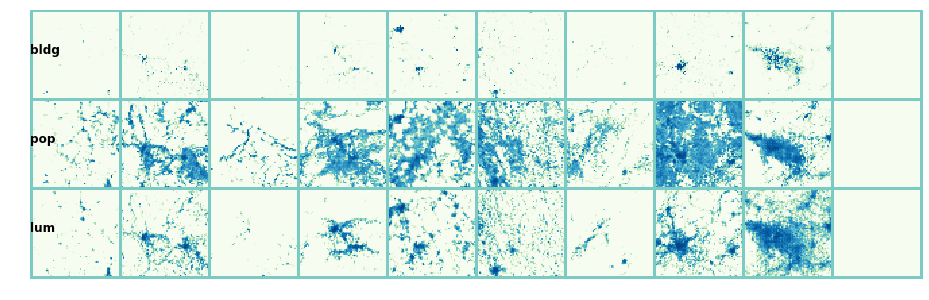

In [7]:
N = 10

Z = np.random.randn(N, z_num)

x_fake = generate_samples(netG, Z.reshape((N,z_num,1,1)), cuda=True)

utils.save_image_channels(x_fake.data, 
                          ncol=x_fake.size()[0], 
                          channel_names=["bldg", "pop", "lum"])

# Explore latent space 
 - a way to assess representation quality introduced in the DCGAN paper

#### Generate interpolation map

In [8]:
def generate_interpolation_map(Z,M):
    N, nz = Z.shape
    Z_map = np.zeros((N-1,M+1,nz))
    for n in range(N-1):
        dZ = (Z[n+1,:] - Z[n,:]) / float(M)
        for m in range(M+1):
            Z_map[n,m,:] = Z[n,:] + m*dZ
        Z_map[n,0,:] = Z[n,:]
        Z_map[n,m,:] = Z[n+1,:]
    Z_map = Z_map.reshape(((N-1)*(M+1), nz))
    return Z_map

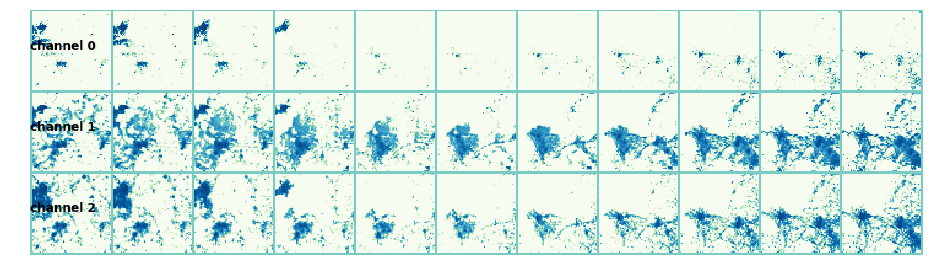

In [9]:
M = 10

Z_map = generate_interpolation_map(Z[[4,1]], M)
x_fake_interp = generate_samples(netG, Z_map, cuda=True)

utils.save_image_channels(x_fake_interp.data, ncol=x_fake_interp.size()[0], 
                          channel_names=["channel %d"%i for i in range(3)])

# Morph between real samples
Recover latent vector of a real image by optimizing a L2 norm of the reconstruction loss.

In [10]:
normalize_channels = ([0, 160.91, 1.295, 0, 0],
                      [1, 1010.413, 15.326, 1, 1])
normalize = normalize_channels
take_log = [1,2]

In [11]:
data_path = "/home/data/world-cities/spatial-maps/samples/"

import glob

files = glob.glob(data_path + "*.tif")
files_dict = {}
for f in files:
    s = f.split("/")
    fname = s[-1]
    country,province,city,pop_class,pop,lat,lon = fname.split("_")
    files_dict["%s, %s, %s"%(city.replace("-"," "),province.replace("-"," "), country.replace("-"," "))] = f
print len(files_dict)

29850


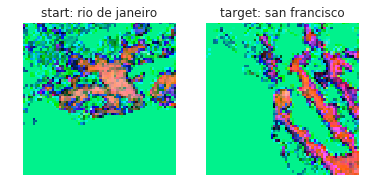

In [12]:
# city_start = "paris, ledefrance, france"
city_start = "rio de janeiro, rio de janeiro, brazil"
city_target= "san francisco, california, united states"
# city_target= "dhaka, dhaka, bangladesh"

img_start  = imread(files_dict[city_start])
img_target = imread(files_dict[city_target])

img_start  = basic_preprocess(img_start, width, log=take_log, normalize=normalize)[...,:3]
img_target = basic_preprocess(img_target, width, log=take_log, normalize=normalize)[...,:3]

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_start); 
ax[1].imshow(img_target); 
_ = ax[0].axis("off"); ax[0].set_title("start: %s"%city_start.split(",")[0])
_ = ax[1].axis("off"); ax[1].set_title("target: %s"%city_target.split(",")[0])

In [14]:
from latent_space import reverse_z

print "learning latent representation for start image"
z_start, loss_start = reverse_z(netG.cuda(), np.expand_dims(img_start.transpose((2,1,0)),0),
                                nz=z_num, cuda=True, clip='stochastic', 
                                lr=0.0002, niter=50000, loss_type='L2')

print "learning latent representation for target image"
z_target, loss_target = reverse_z(netG.cuda(), np.expand_dims(img_target.transpose((2,1,0)),0),
                                  nz=z_num, cuda=True, clip='stochastic', 
                                  lr=0.0002, niter=50000, loss_type='L2')


learning latent representation for start image
[Iter 0/50000] loss_g_z: 2.77666449547
[Iter 5000/50000] loss_g_z: 1.95482957363
[Iter 10000/50000] loss_g_z: 1.88208293915
[Iter 15000/50000] loss_g_z: 1.86879920959
[Iter 20000/50000] loss_g_z: 1.85008180141
[Iter 25000/50000] loss_g_z: 1.84844684601
[Iter 30000/50000] loss_g_z: 1.84844100475
[Iter 35000/50000] loss_g_z: 1.84843957424
[Iter 40000/50000] loss_g_z: 1.84845006466
[Iter 45000/50000] loss_g_z: 1.84846973419
learning latent representation for target image
[Iter 0/50000] loss_g_z: 3.0315246582
[Iter 5000/50000] loss_g_z: 2.06912708282
[Iter 10000/50000] loss_g_z: 2.09921145439
[Iter 15000/50000] loss_g_z: 2.03034520149
[Iter 20000/50000] loss_g_z: 1.99448907375
[Iter 25000/50000] loss_g_z: 1.99095213413
[Iter 30000/50000] loss_g_z: 1.98979711533
[Iter 35000/50000] loss_g_z: 1.98951470852
[Iter 40000/50000] loss_g_z: 1.99003076553
[Iter 45000/50000] loss_g_z: 1.98997151852


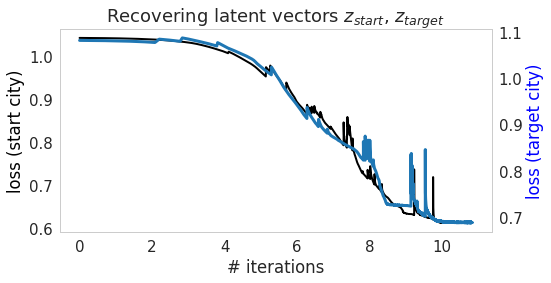

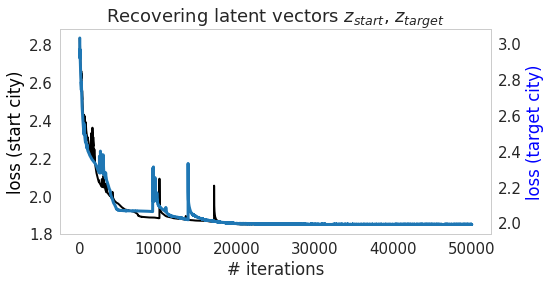

In [24]:
sns.set_context("notebook", font_scale=1.5)

fig, ax1 = plt.subplots(figsize=(8,4))
t = np.arange(0.01, 10.0, 0.01)
ax1.plot(np.log(range(len(loss_start))), np.log(loss_start), lw=2, color='k')
ax1.set_xlabel('# iterations')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('loss (start city)', color='k')

ax2 = ax1.twinx()
ax2.plot(np.log(range(len(loss_start))), np.log(loss_target), lw=3)
ax2.set_ylabel('loss (target city)', color="b")

fig.tight_layout()

plt.title("Recovering latent vectors $z_{start}$, $z_{target}$")

fig, ax1 = plt.subplots(figsize=(8,4))
t = np.arange(0.01, 10.0, 0.01)
ax1.plot(range(len(loss_start)), loss_start, lw=2, color='k')
ax1.set_xlabel('# iterations')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('loss (start city)', color='k')

ax2 = ax1.twinx()
ax2.plot(range(len(loss_start)), loss_target, lw=3)
ax2.set_ylabel('loss (target city)', color="b")

fig.tight_layout()

plt.title("Recovering latent vectors $z_{start}$, $z_{target}$")

In [16]:
img_start_rec = netG(z_start).data.cpu().numpy().squeeze().transpose((1,2,0))
img_target_rec = netG(z_target).data.cpu().numpy().squeeze().transpose((1,2,0))

In [17]:
img_start_rec = basic_preprocess(img_start_rec, 64, normalize=True)
img_target_rec = basic_preprocess(img_target_rec, 64, normalize=True)

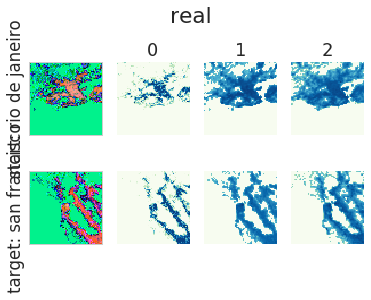

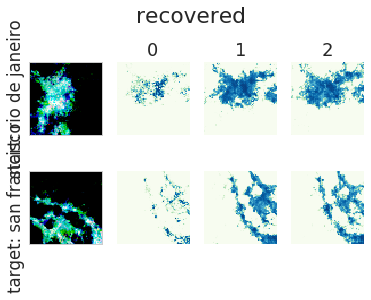

In [46]:
# real images

fig, ax = plt.subplots(2,4)
for c,(img,city) in enumerate(zip([img_start, img_target], [city_start, city_target])):
    ax[c,0].imshow(img[...,:3], cmap=cm.GnBu)
    ax[c,0].set_ylabel(city, rotation=90); 
    ax[c,0].set_xticks([]); ax[c,0].set_yticks([]); 
for c in range(3):
    ax[0,c+1].imshow(img_start[...,c], cmap=cm.GnBu); 
    ax[1,c+1].imshow(img_target[...,c], cmap=cm.GnBu); 
    ax[0,c+1].set_title("%d"%c)
    _ = ax[0,c+1].axis("off"); 
    _ = ax[1,c+1].axis("off"); 

ax[0,0].set_ylabel("start: %s"%city_start.split(",")[0])
ax[1,0].set_ylabel("target: %s"%city_target.split(",")[0])
fig.subplots_adjust(top=0.82)
fig.suptitle("real")

# recovered images

fig, ax = plt.subplots(2,4)
for c,(img,city) in enumerate(zip([img_start_rec, img_target_rec], [city_start, city_target])):
    ax[c,0].imshow(img[...,:3], cmap=cm.GnBu)
    ax[c,0].set_ylabel(city, rotation=90); 
    ax[c,0].set_xticks([]); ax[c,0].set_yticks([]); 
for c in range(3):
    ax[0,c+1].imshow(np.flip(np.rot90(img_start_rec[...,c], k=3),1), cmap=cm.GnBu); 
    ax[1,c+1].imshow(np.rot90(np.flip(img_target_rec[...,c],0),3), cmap=cm.GnBu); 
    ax[0,c+1].set_title("%d"%c)
    _ = ax[0,c+1].axis("off"); 
    _ = ax[1,c+1].axis("off"); 

ax[0,0].set_ylabel("start: %s"%city_start.split(",")[0])
ax[1,0].set_ylabel("target: %s"%city_target.split(",")[0])
fig.subplots_adjust(top=0.82)
fig.suptitle("recovered")

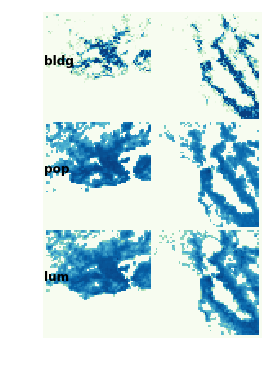

In [19]:
real_img = np.vstack([np.expand_dims(img_start.transpose((2,1,0)),0), 
                      np.expand_dims(img_target.transpose((2,1,0)),0)])
utils.save_image_channels(torch.from_numpy(real_img), normalize=True,
                          ncol=real_img.shape[1], 
                          channel_names=["bldg", "pop", "lum"])

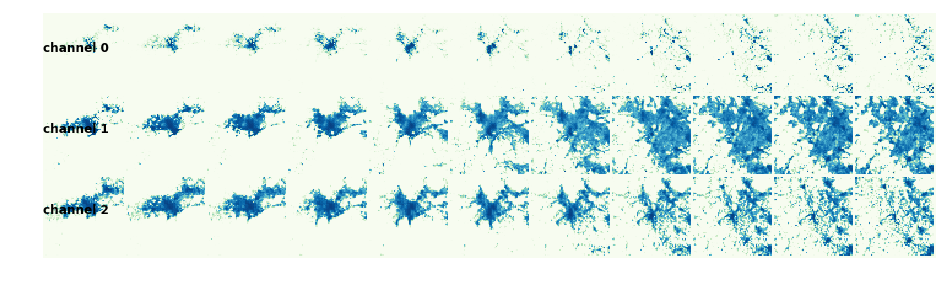

In [20]:
M = 10
Z = np.array([z_start.cpu().data.numpy(), 
              z_target.cpu().data.numpy()]).squeeze()
Z_map = generate_interpolation_map(Z, M)
x_fake_interp = generate_samples(netG.cpu(), Z_map)

utils.save_image_channels(x_fake_interp.data, ncol=x_fake_interp.size()[0],
                          normalize=True,
                          channel_names=["channel %d"%i for i in range(3)])

In [21]:
(Z_map[0,:] == z_start.cpu().data.numpy()).sum()

128

In [22]:
(Z_map[-1,:] == z_target.cpu().data.numpy()).sum()

128

# Extract features for test samples

#### Load discriminator

In [ ]:
# get checkpoints

files_cptD = glob.glob(experiment_dir + "/netD*.pth")
files_cptD = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptD}

last_checkpoint = files_cptD[np.argmax(files_cptD.keys())]

In [ ]:
sys.path.append("../models/")
import models.dcgan_orig as do

ngpu = 2
netD = do._netD(ngpu, nc, ndf)

netD.load_state_dict(torch.load(last_checkpoint))
if torch.cuda.is_available():
    netD.cuda()

feature_extractor = nn.Sequential(*list(list(netD.children())[0].children())[:-2])

#### Set up test data sources

In [ ]:
sys.path.append("./../models/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader
import torchvision.transforms as transforms

test_df = pd.read_csv(dataroot + "/test.csv")

dataset = ImageDataFrame(df=test_df, classCol='city',
                         loader=grayscale_loader,
                         transform=transforms.Compose([
                               transforms.Scale(imageSize),
                               transforms.CenterCrop(imageSize),
                               transforms.ToTensor(),
                               # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

assert dataset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                     shuffle=False, num_workers=int(workers))


#### Extract features from discriminator

In [ ]:
from torch.autograd import Variable

def extract_features(feature_extractor, X):
    '''
    X is a list of data batches or a generator (dataloader).
    '''
    input = torch.FloatTensor(batchSize, nc, imageSize, imageSize)
    if torch.cuda.is_available():
        input = input.cuda()
    input = Variable(input)

    labels = []
    features = []
    for i, data in enumerate(X):
        feature_extractor.zero_grad()
        real_cpu, lab_batch = data
        batch_size = real_cpu.size(0)
        input.data.resize_(real_cpu.size()).copy_(real_cpu)
        feat_batch = feature_extractor(input)
        feat_batch = feat_batch.data.cpu().numpy().reshape((batch_size,-1))

        features.append(feat_batch)
        if lab_batch is not None:
            lab_batch = lab_batch.numpy()
        labels.append(lab_batch)

    features = np.vstack(features)
    labels = np.hstack(labels)
    
    return features, labels

In [ ]:
features, labels = extract_features(feature_extractor, dataloader)

In [ ]:
# import cPickle as pickle
# import gzip

# with gzip.open("test_set_features.pickle.gz", "r") as f:
#     features = pickle.load(f)

In [ ]:
import cPickle as pickle
import gzip

with gzip.open("test_set_features.pickle.gz", "w") as f:
    pickle.dump(features, f)

# Generate lots of synthetic samples
- pass them through the Discriminator to obtain features

In [ ]:
N = 100000
Z = np.random.randn(N, nz)

fake = generate_samples(Z, cuda=False)
# img_fake = fake.data.numpy().squeeze()

n_batches = int(np.ceil(float(N)/batchSize))
fake_batches = [(fake.data[(i*batchSize):min([N,((i+1)*batchSize)])], None) \
                for i in range(n_batches)]

In [ ]:
img_fake = fake.data.numpy().squeeze()
img_fake = 1 - np.abs(img_fake)

In [ ]:
features_fake, labels_fake = extract_features(feature_extractor, fake_batches)

features_fake.shape

In [ ]:
p_fake = pd.Series([img.mean() for img in img_fake])

In [ ]:
p_fake[p_fake<0.45].hist(bins=100)

In [ ]:
large_fake_img = img_fake[(p_fake >= 0.14) & (p_fake <= 0.15)]
print len(large_fake_img)

In [ ]:
for img in large_fake_img[:20]:
    plt.imshow(img)
    plt.show()

# Project to low-d embedding space via t-SNE

In [ ]:
from sklearn import decomposition
N_PCA = 50

pca = decomposition.PCA(n_components=N_PCA)

feats_pca = pca.fit_transform(features)[:,:N_PCA]

plt.figure(figsize=(4,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA Components Variance Explained")
plt.xlabel("# components")
plt.ylabel("% variance")

In [ ]:
# https://github.com/DmitryUlyanov/Multicore-TSNE

from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=32, perplexity=30, n_components=20)
feats_tsne = tsne.fit_transform(features.astype(np.float64))

In [ ]:
feats_tsne.shape

# Similar image search: real cities

In [ ]:
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree, BallTree

myfeatures = features # feats_tsne

tree = BallTree(myfeatures, leaf_size=100)

In [ ]:
# mycities = ["barcelona, es", "athens, gr", "berlin, de", 
#             "hyderabad, in",
#             "boston, us", "san francisco, us"]
mycities = ["san francisco, us", "paris, fr", "delhi, in"]
sel_df = test_df[test_df['city'].apply(lambda s: sum([x in s for x in mycities])>0)]

feats_sel = myfeatures[sel_df.index,:]

n_examples = 4
_, neighbors = tree.query(feats_sel, k=n_examples, dualtree=True)

In [ ]:
from skimage.io import imread, imsave
from skimage.transform import resize

# create canvass
canvass = []
for city0,f0,idx in zip(sel_df['city'], sel_df['filename'], neighbors):
    img0 = imread(f0)
    # imsave(experiment_dir + "./example_%s"%city0, img0)
    row = [np.pad(resize(img0, (100,100)), (2,2), "constant")]
    for _,r in test_df.ix[idx[1:]].iterrows():
        img = imread(r['filename'])
        row.append(np.pad(resize(img, (100,100)), (2,2), "constant"))
    canvass.append(np.hstack(row))
canvass = np.vstack(canvass)

In [ ]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})

# plot
plt.figure(figsize=(20,10))
plt.imshow(canvass)
plt.yticks([])
plt.yticks([52 + i * 104 for i in range(len(sel_df))], [x.split("(")[0].replace(", ", "\n") for x in sel_df['city']])
plt.xticks([52 + i * 104 for i in range(n_examples)], ["query"] + ["nghbr.%d"%i for i in range(n_examples)])
plt.title("Similar Cities")

for i,(city0,f0,idx) in enumerate(zip(sel_df['city'], sel_df['filename'], neighbors)):
    for j,(_,r) in enumerate(test_df.ix[idx].iterrows()):
        city1 = r['city']
        plt.annotate(city1.split("(")[0].replace(", ", "\n"), 
                     xy=(5 + j * 104, 35 + i * 104), 
                     xytext=(5 + j * 104, 35 + i * 104),
                     fontsize=16, color="blue")

# Search similar images: simulations

In [ ]:
tree_fake = KDTree(features_fake)

In [ ]:
mycities = ["san francisco, us", "paris, fr", "delhi, in", 
            "lagos, ng", "bucharest, ro", "rome, it"]
sel_df = test_df[test_df['city'].apply(lambda s: sum([x in s for x in mycities])>0)]
feats_sel = features[sel_df.index,:]

# feats_sel = features_fake[idx_14,:]
# feats_sel = feats_sel[np.random.choice(range(len(feats_sel)), 5, replace=False),:]

n_examples = 5
_, neighbors = tree_fake.query(feats_sel, k=n_examples, breadth_first=True)

In [ ]:
# create canvass
canvass = []
for city0,f0,idx in zip(sel_df['city'], sel_df['filename'], neighbors):
    img0 = imread(f0)
    row = []
    row = [np.pad(resize(img0, (100,100)), (2,2), "constant")]
    for img in img_fake[idx,:]:
        row.append(np.pad(resize(img, (100,100)), (2,2), "constant"))
    canvass.append(np.hstack(row))
canvass = np.vstack(canvass)

In [ ]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})

# plot
plt.figure(figsize=(20,10))
plt.imshow(canvass)
plt.yticks([])
plt.yticks([52 + i * 104 for i in range(len(sel_df))], \
             [x.split("(")[0].replace(", ", "\n") for x in sel_df['city']])
plt.xticks([52 + i * 104 for i in range(n_examples+1)], \
           ["query"] + ["nghbr.%d"%i for i in range(n_examples)])
# plt.title("Simulations similar to real cities")
plt.show()

# Clustering test samples

In [ ]:
from sklearn.cluster import KMeans

feats_reduced = feats_tsne #feats_pca

loss_vec = []
k_vec = np.linspace(5, 100, 40)
for k in k_vec:
    print int(k),
    kmeans = KMeans(n_clusters=int(k), random_state=0).fit(feats_reduced)
    loss = -kmeans.score(feats_reduced)
    loss_vec.append(loss)

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(k_vec, np.array(loss_vec)/1e6)
plt.title("K-Means loss vs # clusters")
plt.xlabel("# Clusters")
plt.ylabel("loss (/1e6)")

In [ ]:
K_opt = 25
kmeans = KMeans(n_clusters=K_opt, random_state=0).fit(feats_tsne)

C = kmeans.predict(feats_tsne)

In [ ]:
(pd.Series(C).value_counts() / float(len(C))).plot(kind="barh", figsize=(4,4))
plt.title("Cluster Membership Distribution")
plt.xlabel("pct membership")
plt.ylabel("cluster ID")

In [ ]:
def plot_examples(image_paths, labels, classes=None, \
                  nExamples=10, thumbSize = (64,64), pad_pix=2, title="example"):
    # build example canvass 
    from skimage.transform import resize
    from skimage.io import imread
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.ones(((thumbSize[0]+pad_pix)*nClusters, nExamples*(thumbSize[1]+pad_pix)))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = imread(image_paths[idx[j]])
            img = img / float(img.max())
            img[abs(img-0.5)<0.01] = 0 # hack to remove no-data patches
            # img = 1-img
            img = resize(img, thumbSize)
            canvas[i*(thumbSize[0]+pad_pix):(i*pad_pix + (i+1)*thumbSize[0]), 
                   j*(thumbSize[1]+pad_pix):(j*pad_pix + (j+1)*thumbSize[1])] = img
    
    # plot examples of each class
    fig,ax = plt.subplots(1, figsize=(12,10))
    plt.tight_layout()
    print canvas.shape
    ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("-- examples --", fontsize=16)
    ax.set_xlabel("-- land classes --", fontsize=16)
    # Turn off tick labels
    if classes is None: classes = clustLabels
    ax.set_xticks([thumbSize[0]*(0.5 + x) for x in range(nClusters)])
    ax.set_xticklabels(classes, fontsize=16, rotation=90)
    ax.set_yticklabels([])
    #plt.axis("off")
    plt.show()

In [ ]:
plot_examples(test_df['filename'].values, C)

# Visualize clusters
- linear grid assignment visualization

#### Standard t-SNE point clouds labeled for the clusters identified by K-Means

In [ ]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

def labeled_scatterplot(x, labels, palette=None, ax=None, add_text=True, alpha=None, figsize=None):
    
    classes = np.unique(labels)
    class_dict = {c:i for i,c in enumerate(classes)}
    n_clust = len(classes)    
    colors = [palette[l] for l in labels]

    # We create a scatter plot.
    if ax is None:
        f = plt.figure(figsize=figsize)
        ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=colors, alpha=alpha)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    if add_text:
        # We add the labels for each class.
        txts = []
        for k,c in enumerate(classes):
            # Position of each label.
            xtext, ytext = np.median(x[labels == c, :], axis=0)
            txt = ax.text(xtext, ytext, str(c), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground=palette[c]),
                PathEffects.Normal()])
            txts.append(txt)

    return ax

In [ ]:
tsne = TSNE(n_jobs=32, perplexity=30, n_components=2)
feats_tsne_2d = tsne.fit_transform(features.astype(np.float64))

In [ ]:
sns.palplot(sns.color_palette("hls", K_opt))

In [ ]:
import matplotlib
palette = dict(zip(range(K_opt), sns.color_palette("hls", K_opt)))
labeled_scatterplot(feats_tsne_2d, C, palette=palette, ax=None, \
                    add_text=True, figsize=None)

#### Stretch point cloud to uniform grid

In [ ]:
from scipy.spatial.distance import cdist

size = 50

grid = np.dstack(np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))).reshape(-1, 2)

idx = np.random.choice(range(len(feats_tsne_2d)), size*size, replace=False)
cost_matrix = cdist(grid, feats_tsne_2d[idx,:], "sqeuclidean").astype(np.float32)
cost_matrix = cost_matrix * (100000 / cost_matrix.max())

In [ ]:
import lapjv

_, row_asses, col_asses = lapjv.lapjv(cost_matrix)

In [ ]:
grid_jv = grid[row_asses]
pp_cmap = matplotlib.colors.ListedColormap(palette.values())
for start, end, t in zip(feats_tsne_2d[idx,:], grid_jv, C[idx]):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
          head_length=0.005, head_width=0.005, color=pp_cmap(t), alpha=0.5)
#colorbar(my_colorbar.mappable, fraction=0.05, pad = 0.0125)
plt.xticks([]); plt.yticks([])

# Clustering analysis 

In [ ]:
test_df.head()

In [ ]:
regions_df = pd.read_csv("/home/adalbert/data/countries_regions.csv")

country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}

test_df['region'] = test_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)

print "Could not map to regions %d out of %d cities."%(test_df['region'].isnull().sum(), len(test_df))

In [ ]:
df = test_df[["filename", 'region', 'decile', 'built pct', 'class']]
df['cluster'] = C

In [ ]:
df.head()

In [ ]:
df.groupby("region").apply(lambda x: x['cluster'].value_counts() / float(len(x))).unstack()\
    .plot(kind="bar", stacked=True, figsize=(6,4), cmap=pp_cmap)
plt.legend(bbox_to_anchor=(1.2, 1.15), fontsize=12)
plt.title("World-wide distribution of city types", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
df.head()

In [ ]:
df.head()

In [ ]:
stats = df.groupby(["cluster"]).apply(lambda x: (x['built pct'].mean().round(3), 
                                         x['built pct'].std().round(3)))

In [ ]:
df.boxplot(column="built pct", by="cluster")

In [ ]:
df.groupby("cluster").apply(len).plot(kind="bar")

In [ ]:
idx = df['cluster']==0
plot_examples(df[idx]['filename'].values, 
              df[idx]['region'].values, nExamples=4) 